### 목적
- 복잡한 애플리케이션을 여러 개의 전문 에이전트로 분할아여 문제 해결을 위해 함께 작동

#### 다중에이전트
- 하나의 에이전트에 너무 많은 도구를 가지고 있으면, 어떤 도구를 사용할지에 대한 잘못된 결정을 내린다.
- 맥락이나 기억이 너무 커져서 하나의 에이전트가 추적하기 어려움
- 전문성을 나누어 조율된 워크플로우 구성 (예시: 분석 전문가 , 요약 전문가 등)

#### 다중에이전트 패턴
- LangChain/LangGraph에서 다중에이전트를 설계할 때는 두 가지 접근 방법이 있다.

| 패턴                  | 작동 방식                                                                                                          | 제어 흐름(Control flow)                                  | 대표 사례                     |
| ------------------- | -------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------- | ------------------------- |
|  **Tool Calling** | “감독자(Supervisor)” 에이전트가 다른 에이전트들을 **도구(tools)**처럼 호출한다. <br> 하위 에이전트들은 사용자를 직접 상대하지 않고, 요청받은 작업만 수행해 결과를 반환한다. | **중앙집중형(Centralized)** — 모든 요청과 응답은 Supervisor를 거친다. | 워크플로우 오케스트레이션, 단계적 태스크 관리 |
|  **Handoffs**     | 현재 활성화된 에이전트가 “이건 다른 에이전트가 맡는 게 낫겠어” 하고 **제어권(Control)을 넘긴다.** <br> 사용자도 새 에이전트와 직접 대화하게 된다.                   | **분산형(Decentralized)** — 에이전트 간에 “주도권”이 바뀐다.         | 도메인별 전문 상담, 대화형 멀티-봇 협업   |



#### 구조적 분류
- LangChain에서 다중에이전트는 3가지 패턴으로 구현할 수 있다.

| 유형                                     | 설명                                              | 예시                                  |
| -------------------------------------- | ----------------------------------------------- | ----------------------------------- |
| **병렬형 (Parallel)**                     | 여러 에이전트가 동시에 작업을 수행한 뒤 결과를 병합                   | 예: 요약/번역/감성분석 동시 수행                 |
| **직렬형 (Sequential)**                   | 앞 에이전트의 결과를 다음 에이전트가 이어받아 처리                    | 예: 검색 → 요약 → 평가                     |
| **조정형 (Coordinator / Manager-Worker)** | 상위 조정자(Coordinator)가 하위 에이전트들을 호출하고, 각자의 결과를 취합 | 예: 프로젝트 매니저 Agent가 3명의 팀원 Agent를 지휘 |


#### Tool Calling
- 컨트롤러가 다른 에이전트들을 필요할 때 호출되는 도구로 취급한다.
    - 컨트롤러는 **오케스트레이션**을 관리 
    - **오케스트레이션**: 전체 흐름 설계, 각 에이전트 호출 순서, 조건, 데이터 전달, 종료 조건 등을 중앙에서 지휘자가 조율하는 구조
- 하위 에이전트들은 사용자와의 연결이 없다. -> 필요하다면 handoff 방식 사용
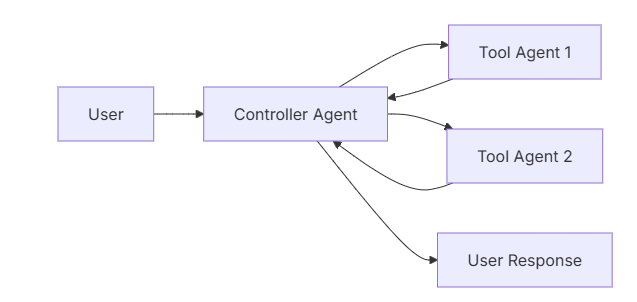

In [1]:
# tool calling 패턴 -> 슈퍼바이저가 서브에이전트를 툴처럼 호출

import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.tools import tool, ToolRuntime

load_dotenv()

llm = ChatOpenAI(model='gpt-4o-mini', api_key=os.getenv('OPENAI_API_KEY'))

@tool
def add(a: int, b: int) -> int:
    """두 정수 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """두 정수 a와 b를 곱합니다."""
    return a * b

@tool
def divide(a: int, b: int) -> float:
    """a를 b로 나눕니다. 0으로는 나눌 수 없습니다."""
    if b == 0:
        raise ValueError("0으로는 나눌 수 없습니다.")
    return a / b

# 서브에이전트: 연산 전문가
calc_subagent = create_agent(model=llm, tools=[add, multiply, divide])

# 상위에이전트에서 호출할 서브에이전트 -> 툴 처럼 정의
@tool("calc_subagent")
def call_calc_agent(query: str):
    """description="연산 전문가 서브에이전트에게 계산을 위임합니다. 자연어 수식/계산 요청만 넘기세요."""
    result = calc_subagent.invoke({
        'messages': [{'role': 'user', 'content': query}]
    })
    return result['messages'][-1].content 
    # 서브에이전트가 툴로써 호출되었기 때문에 슈퍼바이저에게 ToolMessage객체로 들어간다.

agent = create_agent(model=llm, tools=[call_calc_agent])

result = agent.invoke({
    "messages": [{"role": "user", "content": "calc_exec로 (12 + 7) * 3 계산해줘"}]
})

print(result["messages"][-1].content)

계산 결과는 \( 57 \)입니다.


#### 하위에이전트 입력 제어
- 슈퍼바이저가 하위에이전트에게 전달하는 입력을 제어하는 두 가지 주요 수단
    - 프롬프트 수정: 메인 에이전트의 프롬프트나 도구 메타데이터를 조정하여 서브에이전트를 호출하는 시기와 방법을 더 잘 안내한다.
    - 컨텍스트 주입: 에이전트의 상태에서 가져오도록 도구 호출을 조정하여 정적 프롬프트에 어려운 입력(전체 메시지 기록, 이전 결과 등)을 추가한다.

In [ ]:
import os
from dotenv import load_dotenv
from langchain.agents import AgentState
from langchain.tools import tool, ToolRuntime

load_dotenv()

llm = ChatOpenAI(model='gpt-4o-mini', api_key=os.getenv('OPENAI_API_KEY'))

class ConversationState(AgentState):
    topic: str

subagent = create_agent(
    model=llm,
    tools=[],
    state_schema=ConversationState # 슈퍼바이저와 같은 state_schema를 사용해야 한다.
)

def build_subagent_messages(question: str, full_messages: list, topic: str) -> list:
    """
    슈퍼바이저의 전체 대화 중에 마지막 메시지 3개 + 현재 질문(question)만 서브에이전트에게 전달
    topic은 system 프롬프트에 녹여서 전달
    """
    # 서브에이전트 툴 입장에선 tool 메시지나 tool_calls가 있는 assistant 메시지는 볼 필요가 없다.
    # 사용자와의 대화 내용만 중요함
    # 불필요한 메시지들을 걸러낸다.
    cleaned = []
    for m in full_messages:
        if isinstance(m, dict):
            role = m.get("role")

            # tool 메시지는 버린다
            if role == "tool":
                continue

            # assistant인데 tool_calls가 있으면 이것도 버린다
            if role == "assistant" and m.get("tool_calls"):
                continue

            cleaned.append(m)

    return [
        {
            "role": "system",
            "content": (
                "너는 보조 전문가 서브에이전트이다."
                f"현재 대화 주제는 '{topic}'이다."
                "주어진 최근 대화와 새로운 질문만 보고 답변해라."
            ),
        }, # 프롬프트 주입
        *cleaned, # 컨텍스트 주입 -> 최근 대화
        {"role": "user", "content": question},
    ]

@tool("ask_subagent", description="현재 대화 주제를 바탕으로 서브에이전트에게 질문을 위임합니다.")
def call_subagent(
    question: str,
    runtime: ToolRuntime[None, ConversationState],
) -> str:
    """
    runtime.state에서 메인 에이전트의 전체 대화 및 topic을 읽고
    서브에이전트에 넘길 messages를 직접 만들어서
    서브에이전트를 호출한 뒤, 마지막 답변 content만 반환한다.
    """
    print("서브에이전트 call_subagent 툴 호출 중...")

    # 1. state 읽기
    state = runtime.state
    full_messages = state["messages"] # 지금까지의 전체 대화
    topic = state["topic"] # 현재 대화 주제(슈퍼바이저에서 공유)

    # 2. 서브에이전트용 입력 메시지 구성
    sub_messages = build_subagent_messages(
        question=question,
        full_messages=full_messages,
        topic=topic,
    )

    # 3. 서브에이전트 호출
    result = subagent.invoke({
        "messages": sub_messages,
        "topic": topic, # 서브에이전트의 state_schema에도 topic이 있으므로 그대로 전달 가능
    })
    
    return result["messages"][-1].content

agent = create_agent(
    model=llm,
    tools=[call_subagent], # 서브에이전트 툴 등록
    state_schema=ConversationState, # 서브에이전트와 같은 state_schema 사용
)

result = agent.invoke({
    "messages": [
        {"role": "user", "content": "오늘 서울 날씨 어때?"},
        {"role": "assistant", "content": "오늘은 맑고 화창한 날씨입니다."},
        {"role": "user", "content": "그럼 서울 내일은?"},
        {"role": "assistant", "content": "내일은 약간 흐리고 오후에 비가 올 예정입니다."},
        {"role": "user", "content": "모레 서울 날씨는 어떨까?"}
    ],
    "topic": "날씨", # state에 대화 주제 추가
})

# print(result["messages"][-1].content)
from pprint import pprint
pprint(result["messages"])

서브에이전트 call_subagent 툴 호출 중...
[HumanMessage(content='오늘 서울 날씨 어때?', additional_kwargs={}, response_metadata={}, id='b81e9eae-ab05-4a37-91c1-9687440275c0'),
 AIMessage(content='오늘은 맑고 화창한 날씨입니다.', additional_kwargs={}, response_metadata={}, id='1d958c1b-5a6a-4acc-9707-1cfcc061396f'),
 HumanMessage(content='그럼 서울 내일은?', additional_kwargs={}, response_metadata={}, id='1d78efae-1ad3-4568-ade7-3fbd30c87605'),
 AIMessage(content='내일은 약간 흐리고 오후에 비가 올 예정입니다.', additional_kwargs={}, response_metadata={}, id='2cc7fe92-69ae-4425-a61b-f21cde69c2da'),
 HumanMessage(content='모레 서울 날씨는 어떨까?', additional_kwargs={}, response_metadata={}, id='4cd168cf-c0bf-4098-8be9-08112f550bf7'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 126, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details':

#### 서브에이전트 출력 제어
- 슈퍼바이저가 서브에이전트로부터 무엇을 받을지 결정
    - 프롬프트 수정: 하위 에이전트의 프롬프트를 세부적으로 조정하여 반환해야 할 내용을 정확하게 지정
        - 출력이 불완전하거나 너무 자세하거나 주요 세부 정보가 누락된 경우에 유용
        - 컨트롤러 및 사용자는 최종 출력만 볼 수 있으므로 하위 에이전트에서의 모든 관련 정보를 최종 출력에 포함해야 한다.

    - 사용자 정의 출력 형식: 슈퍼바이저에게 다시 전달하기 전에 하위 에이전트의 응답을 코드로 조정하거나 풍부하게 만든다.
        - 최종 텍스트 외에 특정 상태 키를 슈퍼바이저에게 다시 전달
        - 결과를 Command로 래핑하여 사용자 정의 상태를 하위 에이전트의 응답과 병합해야 한다.

In [18]:
import os
from dotenv import load_dotenv
from typing import Annotated, Optional
from langchain_openai import ChatOpenAI
from langchain.tools import tool, InjectedToolCallId
from langchain.agents import create_agent, AgentState
from langchain_core.messages import ToolMessage
from langgraph.types import Command

load_dotenv()

llm = ChatOpenAI(model='gpt-4o-mini', api_key=os.getenv('OPENAI_API_KEY'))

class TrevelState(AgentState):
    subagent_summary: Optional[str] = None

# 서브에이전트 정의
planner_subagent = create_agent(
    model=llm,
    tools=[],
    state_schema=TrevelState,
)

@tool(
    "planner_subagent_tool", 
    description="여행 일정 및 동선을 설계하는 서브 에이전트에게 작업을 위임합니다."
)
def call_planner_subagent(
    query: str,
    tool_call_id: Annotated[str, InjectedToolCallId] # ToolRuntime에는 tool_call_id가 없어서 주입받아야 한다.
) -> Command:
    """
    메인 에이전트에서 서브에이전트 호출을 담당하는 툴
    - query: 메인에이전트가 서브에이전트에게 넘길 자연어 요청
    - tool_call_id: 런타임이 주입하는 툴 호출 ID
    - 반환값: Command(update=...)로 state와 messages를 동시에 업데이트
    """

    # 1. 서브에이전트에게 유저 질문 전달
    subagent_result = planner_subagent.invoke(
        {
            "messages": [
                {"role": "user", 
                 "content": (
                     "너는 여행 플래너야. 동선이 편하고 현실적인 1박 2일 코스를 설계해줘. \n"
                     f"사용자 요청: {query}"
                 )
                }
            ]
        }
    )

    # 2. 서브에이전트의 마지막 메시지를 추출
    final_msg = subagent_result['messages'][-1].content

    # 3. Command로 state를 갱신하고 ToolMessage(tool_call_id=...)를 messages에 추가해서
    #    메인 에이전트가 서브에이전트의 응답을 인지하도록 한다.
    return Command(
        update={
            "subagent_summary": final_msg,
            "messages": [
                ToolMessage(
                    tool_call_id=tool_call_id,
                    content=final_msg
                )
            ]
        }
    )

main_agent = create_agent(
    model=llm,
    tools=[call_planner_subagent],
    state_schema=TrevelState,
)

result = main_agent.invoke({
    "messages": [
        {"role": "user", "content": "서울에서 1박 2일 여행 코스를 추천해줘."}
    ]
})

# result에는 state도 messages와 함께 들어있어서 확인 가능
print("[state에 저장된 값]\n", result["subagent_summary"]) 
# print("[응답메시지 확인]\n", result["messages"][-1].content)

[state에 저장된 값]
 서울에서의 1박 2일 여행 코스를 아래와 같이 추천드립니다. 이 코스는 동선이 편리하고 서울의 다양한 매력을 즐길 수 있도록 짜여져 있습니다.

### 1일차: 서울의 역사와 문화 탐방

**오전: 경복궁 & 북촌 한옥마을**  
- **경복궁**: 아침 일찍 경복궁을 방문해 경복궁과 국립민속박물관을 관람합니다. 궁 내에서의 조용한 산책을 즐기세요.
- **북촌 한옥마을**: 경복궁에서 도보로 10분 거리에 위치한 북촌 한옥마을을 탐방합니다. 전통 가옥과 아름다운 골목길을 산책하며 사진을 찍어보세요.

**점심: 북촌 한옥마을 인근의 전통 한식당**  
- 한식당에서 비빔밥이나 불고기 같은 전통 음식을 즐겨보세요.

**오후: 인사동 & 명동**  
- **인사동**: 예술과 전통이 어우러진 인사동 거리에서 갤러리, 찻집, 기념품 가게를 구경합니다.
- **명동**: 명동으로 이동하여 쇼핑을 즐기고, 가벼운 간식을 맛보세요. 명동의 다양한 스트리트 푸드를 경험할 수 있습니다.

**저녁: 남산타워 & 저녁식사**  
- **남산타워**: 저녁에는 남산타워에 올라 서울의 전경을 감상합니다. 케이블카를 이용할 수 있습니다.
- **저녁식사**: 남산 근처에 있는 레스토랑에서 한식을 즐기며 하루를 마무리합니다.

**숙소: 명동 또는 인사동 근처**  
- 명동이나 인사동 지역의 호텔이나 게스트하우스에 숙박합니다.

---

### 2일차: 현대적 서울 경험

**오전: 홍대 거리 & 프리마켓**  
- **홍대**: 아침에 홍대입구역으로 가서 홍대 거리와 상점들을 탐방합니다. 아트와 음악의 성지인 이곳에서 다양한 스트리트 공연도 감상하세요.
- **프리마켓**: 특히 주말에는 홍대 프리마켓을 방문해 예술가들의 작품을 구경하고 구매할 수 있습니다.

**점심: 홍대 지역 카페**  
- 트렌디한 카페에서 브런치를 즐깁니다.

**오후: 여의도 한강공원**  
- **여의도 한강공원**: 지하철로 이동하여 한강을 따라 산책, 자전거 대여,

#### 핸드오프(handoffs)
- 에이전트가 서로에게 직접 제어권을 넘길 수 있다.
- 활성 에이전트가 변경되고, 사용자는 현재 제어권을 가진 에이전트와 상호 작용한다.
- 흐름
    1. 현재 에이전트는 다른 에이전트의 도움이 필요하다고 결정
    2. 이는 제어권 및 상태를 다음 에이전트에게 넘김
    3. 새로운 에이전트는 다시 인계하거나 완료할 때까지 사용자와 상호 작용
    
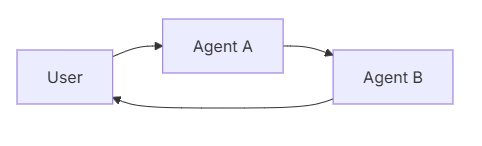

In [64]:
# agent를 사용하여 핸드오프 구성
import os
from typing import Literal, Optional
from dotenv import load_dotenv

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

load_dotenv()

llm = ChatOpenAI(model='gpt-4o-mini', api_key=os.getenv('OPENAI_API_KEY'))

# 에이전트 공통 응답 포맷 정의
class HandOffResponse(BaseModel):
    """
    에이전트가 반드시 이 형식으로 응답하게 강제한다.
    - mode:
        * "answer"  : 그냥 내가 답변하고 끝낸다.
        * "handoff" : 다른 에이전트에게 넘긴다.
    - target_agent:
        * handoff일 때만 사용. 예: "math", "general" 등
    - message:
        * 실제 유저에게 보여줄 자연어 답변
    """
    mode: Literal["answer", "handoff"] = Field(
        description="답변으로 끝낼지, 다른 에이전트에게 넘길지 결정"
    )
    target_agent: Optional[Literal["general", "math"]] = Field(
        default=None,
        description="handoff 모드일 때 넘길 에이전트 이름"
    )
    message: str = Field(
        description="사용자에게 보여줄 자연어 답변"
    )

# 일반 에이전트 생성
general_agent = create_agent(
    model=llm,
    tools=[],
    response_format=HandOffResponse, # HandOffResponse 이외 형식은 허용하지 않음
)

# 수학 전문 에이전트 생성
math_agent = create_agent(
    model=llm,
    tools=[],
    response_format=HandOffResponse,
)

# 에이전트 호출 helper
def call_general_agent(user_message: str, history: list):
    """
    general_agent 호출 함수
    - user_message: 방금 들어온 유저 메시지(문자열)
    - history: 지금까지의 대화 (HumanMessage, AIMessage 리스트)

    general_agent에게는 다음과 같이 프롬프트를 구성해서 넘긴다.
    1) system: general_agent 역할 설명
    2) history: 이전 대화 내용
    3) user: 이번에 새로 들어온 질문
    """
    system = SystemMessage(
        content=(
            "너는 일반 상담 담당 에이전트이다."
            "사용자의 요청을 먼저 이해하고, 다음 중 하나를 선택해야 한다.\n"
            "1) 일반적인 정보/상담으로 충분하면 mode='answer'로 답변하고,"
            "target_agent는 None으로 둔다.\n"
            "2) 질문이 수학/계산 중심이라면 mode='handoff'로 하고,"
            "target_agent='math'로 설정하고"
            "'수학 전문 에이전트에게 넘기겠다'는 친절한 안내를 넣어라.\n"
            "반드시 HandOffResponse 형식으로 응답해야 한다."
        )
    )

    messages = [system] + history + [HumanMessage(content=user_message)]

    result = general_agent.invoke({"messages": messages})

    ai_msg = result["messages"][-1]
    structured: HandOffResponse = result["structured_response"]

    return ai_msg, structured

def call_math_agent(user_message: str, history: list):
    """
    math_agent 호출 함수.

    - user_message: 원래 사용자가 했던 '수학/계산 질문'
    - history: 지금까지의 대화 기록

    math_agent에게는:
    1) system: 수학/계산 전문가 역할 설명
    2) history: general agent가 했던 설명 등
    3) user: 원래의 수학 질문(또는 handoff 이후 수정된 질문)을 다시 넘겨준다.
    """
    system = SystemMessage(
        content=(
            "너는 수학/계산 전문가 에이전트이다. "
            "사용자의 계산/수학 질문을 단계별로 아주 쉽게 설명해야 한다. "
            "계산 과정과 최종 결과를 모두 포함하고, 중학생이 이해할 수 있게 풀어서 설명해라. "
            "반드시 HandoffResponse 형식에 맞게 응답해라. "
            "이 에이전트에서는 mode='answer' 만 사용하고, "
            "target_agent 는 항상 None 으로 둔다."
        )
    )
    messages = [system] + history + [HumanMessage(content=user_message)]
    result = math_agent.invoke({"messages": messages})

    ai_msg = result["messages"][-1]
    structured: HandOffResponse = result["structured_response"]

    return ai_msg, structured

# 드라이버: 핸드오프 실행
def chat_with_handoff(user_message: str):
    """
    한 번의 사용자 입력에 대해

    1) general_agent가 먼저 응답/판단
    2) 필요하면 math_agent로 handoff
    3) 최종적으로 사용자에게 보여줄 메시지들을 리턴

    반환:
        history: Human/AI 메시지 전체 리스트
    """
    history: list = []  # HumanMessage / AIMessage 리스트

     # 1) general_agent 먼저 호출
    general_ai, general_struct = call_general_agent(user_message, history)
    history.append(HumanMessage(content=user_message))
    history.append(AIMessage(content=general_struct.message))

    # 2) general_agent의 의사결정 확인
    if general_struct.mode == "answer":
        # 그냥 일반 상담으로 끝낸다.
        print("[general_agent 응답]")
        print(general_struct.message)
        return history

    if general_struct.mode == "handoff" and general_struct.target_agent == "math":
        # 수학 에이전트로 handoff
        print("[general_agent 안내]")
        print(general_struct.message)

        # math_agent 에 넘길 때는
        # 원래 유저 질문을 그대로 math_agent에 전달하는 식으로 구현
        math_ai, math_struct = call_math_agent(user_message, history)
        history.append(math_ai)

        print("\n[math_agent 응답]")
        print(math_struct.message)

        return history
    
    # 그 외 처리
    print("[경고] 예상치 못한 응답 모드:", general_struct)
    return history

# 테스트
print("===== 예시 1: 일반 질문 =====")
chat_with_handoff("서울에서 제일 유명한 음식점 알려줘")

print("\n\n===== 예시 2: 수학/계산 질문 (handoff 발생) =====")
chat_with_handoff("12.5 곱하기 4.2의 결과에 log2를 더한 값을 알려줘")

===== 예시 1: 일반 질문 =====
[general_agent 응답]
서울에서 유명한 음식점으로는 '가온', '미슐랭가이드'에 선정된 다양한 레스토랑, 그리고 '명동교자', '부산갈비', '삼청동수제비'와 같은 전통적인 한식 집들이 있습니다. 각 음식점마다 독특한 메뉴와 분위기가 있으니 방문해보시면 좋을 것 같습니다.


===== 예시 2: 수학/계산 질문 (handoff 발생) =====
[general_agent 안내]
질문이 수학 계산 중심이라서 수학 전문 에이전트에게 넘기겠습니다.

[math_agent 응답]
먼저 12.5와 4.2를 곱해 보겠습니다.

1. **곱하기 계산**  
   12.5 × 4.2 = 52.5 입니다.

다음으로, 이 결과에 log2를 더합니다.

2. **log2 계산**  
   log2(52.5)의 값을 구하려면, 52.5가 2 몇 번 곱해졌는지를 알아야 합니다.  
   이걸 계산기나 로그 테이블을 사용하여 구하면, 대략 5.7입니다.

3. **결과 더하기**  
   5.7 + 52.5 = 58.2 입니다.

따라서, 12.5 곱하기 4.2의 결과에 log2를 더한 값은 약 58.2입니다.


[HumanMessage(content='12.5 곱하기 4.2의 결과에 log2를 더한 값을 알려줘', additional_kwargs={}, response_metadata={}, id='0f3d3db4-e392-42b3-9cae-e014f78fec80'),
 AIMessage(content='질문이 수학 계산 중심이라서 수학 전문 에이전트에게 넘기겠습니다.', additional_kwargs={}, response_metadata={}, id='961805ec-aaa2-4474-941a-e36d2e563709'),
 ToolMessage(content="Returning structured response: mode='answer' target_agent=None message='먼저 12.5와 4.2를 곱해 보겠습니다.\\n\\n1. **곱하기 계산**  \\n   12.5 × 4.2 = 52.5 입니다.\\n\\n다음으로, 이 결과에 log2를 더합니다.\\n\\n2. **log2 계산**  \\n   log2(52.5)의 값을 구하려면, 52.5가 2 몇 번 곱해졌는지를 알아야 합니다.  \\n   이걸 계산기나 로그 테이블을 사용하여 구하면, 대략 5.7입니다.\\n\\n3. **결과 더하기**  \\n   5.7 + 52.5 = 58.2 입니다.\\n\\n따라서, 12.5 곱하기 4.2의 결과에 log2를 더한 값은 약 58.2입니다.'", name='HandOffResponse', id='0f7499bf-8e20-43f7-9a87-7dd103417bac', tool_call_id='call_52rMlPEuUaZXCk8Q0CasvNsI')]

#### 툴도 사용하지 않았고 history에 AI의 답변(AIMessage)을 추가했는데 왜 ToolMessage가 들어갈까?
- 에이전트에 response_format=Schema을 지정하면 LangChain 내부적으로는 아래 로직이 진행된다.
    - 모델의 지원에 따라 response_format을 ProviderStrategy(Schema) 또는 ToolStrategy(Schema)로 지정한다.
    - 이 때, 모델이 ToolStrategy를 사용할 경우 LangChain이 **구조화 출력용 툴**을 자동으로 추가한다.
    - 즉, LangChain이 명백히 tool-calling을 했기 때문에 ToolMessage로 출력된다.
- gpt-4o-mini는 ToolMessage이지만 gpt-5는 AIMessage로 출력된다.

#### Pydantic이란?
- 파이썬 타입 힌트(type hint)를 이용해서, 데이터 검증·변환을 자동으로 해주는 라이브러리
- 예시) BaseModel
- 공식적으로 지원하는 것은 BaseModel을 상속받은 라인이지만 **schema() 또는 model_json_schema() 같은 메소드로 JSON 스키마를 뽑을 수 있는 타입**을 전제로 구현되어 있다.

In [ ]:
# agent를 사용하여 핸드오프 구성
import os
from typing import Literal, Optional
from dotenv import load_dotenv

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

load_dotenv()

llm = ChatOpenAI(model='gpt-5-nano', api_key=os.getenv('OPENAI_API_KEY'))

# 에이전트 공통 응답 포맷 정의
class HandOffResponse(BaseModel):
    """
    에이전트가 반드시 이 형식으로 응답하게 강제한다.
    - mode:
        * "answer"  : 그냥 내가 답변하고 끝낸다.
        * "handoff" : 다른 에이전트에게 넘긴다.
    - target_agent:
        * handoff일 때만 사용. 예: "math", "general" 등
    - message:
        * 실제 유저에게 보여줄 자연어 답변
    """
    mode: Literal["answer", "handoff"] = Field(
        description="답변으로 끝낼지, 다른 에이전트에게 넘길지 결정"
    )
    target_agent: Optional[Literal["general", "math"]] = Field(
        default=None,
        description="handoff 모드일 때 넘길 에이전트 이름"
    )
    message: str = Field(
        description="사용자에게 보여줄 자연어 답변"
    )

# 일반 에이전트 생성
general_agent = create_agent(
    model=llm,
    tools=[],
    response_format=HandOffResponse, # HandOffResponse 이외 형식은 허용하지 않음
)

# 수학 전문 에이전트 생성
math_agent = create_agent(
    model=llm,
    tools=[],
    response_format=HandOffResponse,
)

# 에이전트 호출 helper
def call_general_agent(user_message: str, history: list):
    """
    general_agent 호출 함수
    - user_message: 방금 들어온 유저 메시지(문자열)
    - history: 지금까지의 대화 (HumanMessage, AIMessage 리스트)

    general_agent에게는 다음과 같이 프롬프트를 구성해서 넘긴다.
    1) system: general_agent 역할 설명
    2) history: 이전 대화 내용
    3) user: 이번에 새로 들어온 질문
    """
    system = SystemMessage(
        content=(
            "너는 일반 상담 담당 에이전트이다."
            "사용자의 요청을 먼저 이해하고, 다음 중 하나를 선택해야 한다.\n"
            "1) 일반적인 정보/상담으로 충분하면 mode='answer'로 답변하고,"
            "target_agent는 None으로 둔다.\n"
            "2) 질문이 수학/계산 중심이라면 mode='handoff'로 하고,"
            "target_agent='math'로 설정하고"
            "'수학 전문 에이전트에게 넘기겠다'는 친절한 안내를 넣어라.\n"
            "반드시 HandOffResponse 형식으로 응답해야 한다."
        )
    )

    messages = [system] + history + [HumanMessage(content=user_message)]

    result = general_agent.invoke({"messages": messages})

    ai_msg = result["messages"][-1]
    structured: HandOffResponse = result["structured_response"]

    return ai_msg, structured

def call_math_agent(user_message: str, history: list):
    """
    math_agent 호출 함수.

    - user_message: 원래 사용자가 했던 '수학/계산 질문'
    - history: 지금까지의 대화 기록

    math_agent에게는:
    1) system: 수학/계산 전문가 역할 설명
    2) history: general agent가 했던 설명 등
    3) user: 원래의 수학 질문(또는 handoff 이후 수정된 질문)을 다시 넘겨준다.
    """
    system = SystemMessage(
        content=(
            "너는 수학/계산 전문가 에이전트이다. "
            "사용자의 계산/수학 질문을 단계별로 아주 쉽게 설명해야 한다. "
            "계산 과정과 최종 결과를 모두 포함하고, 중학생이 이해할 수 있게 풀어서 설명해라. "
            "반드시 HandoffResponse 형식에 맞게 응답해라. "
            "이 에이전트에서는 mode='answer' 만 사용하고, "
            "target_agent 는 항상 None 으로 둔다."
        )
    )
    messages = [system] + history + [HumanMessage(content=user_message)]
    result = math_agent.invoke({"messages": messages})

    ai_msg = result["messages"][-1]
    structured: HandOffResponse = result["structured_response"]

    return ai_msg, structured

# 드라이버: 핸드오프 실행
def chat_with_handoff(user_message: str):
    """
    한 번의 사용자 입력에 대해

    1) general_agent가 먼저 응답/판단
    2) 필요하면 math_agent로 handoff
    3) 최종적으로 사용자에게 보여줄 메시지들을 리턴

    반환:
        history: Human/AI 메시지 전체 리스트
    """
    history: list = []  # HumanMessage / AIMessage 리스트

     # 1) general_agent 먼저 호출
    general_ai, general_struct = call_general_agent(user_message, history)
    history.append(HumanMessage(content=user_message))
    history.append(AIMessage(content=general_struct.message))

    # 2) general_agent의 의사결정 확인
    if general_struct.mode == "answer":
        # 그냥 일반 상담으로 끝낸다.
        print("[general_agent 응답]")
        print(general_struct.message)
        return history

    if general_struct.mode == "handoff" and general_struct.target_agent == "math":
        # 수학 에이전트로 handoff
        print("[general_agent 안내]")
        print(general_struct.message)

        # math_agent 에 넘길 때는
        # 원래 유저 질문을 그대로 math_agent에 전달하는 식으로 구현
        math_ai, math_struct = call_math_agent(user_message, history)
        history.append(math_ai)

        print("\n[math_agent 응답]")
        print(math_struct.message)

        return history
    
    # 그 외 처리
    print("[경고] 예상치 못한 응답 모드:", general_struct)
    return history

# 테스트
print("===== 예시 1: 일반 질문 =====")
chat_with_handoff("서울에서 제일 유명한 음식점 알려줘")

print("\n\n===== 예시 2: 수학/계산 질문 (handoff 발생) =====")
chat_with_handoff("12.5 곱하기 4.2의 결과에 log2를 더한 값을 알려줘")

===== 예시 1: 일반 질문 =====
[general_agent 응답]
서울에서 '제일 유명한' 음식점을 하나로 꼽기는 주관적이라 상황에 따라 다릅니다. 대중적으로 널리 알려진 곳들을 몇 가지 추천해 드리면 다음과 같아요.

- Tosokchon Samgyetang(토속촌 삼계탕): 경복궁 근처의 전통 삼계탕 명소로, 한국식 보양 음식의 대표격입니다. 점심시간대에 붐비는 편이고 대기 시간이 생길 수 있어요.
- Jungsik(정식당): 청담동의 현대 한식 파인다이닝으로 세계적으로 인정받은 곳입니다. 코스 요리 위주이고 가격대가 높은 편입니다.
- Mingles(밍글스): 강남·청담 인근의 현대 한국식 퀴진으로 미슐랭 스타를 받은 곳입니다. 창의적 메뉴를 즐길 수 있습니다.
- 광장시장 인근의 전통 포장마차/식당들: 전통 한국 음식을 다채롭게 맛볼 수 있는 캐주얼한 옵션들로, 분위기를 느끼기에 좋습니다.

다만 취향에 따라 분위기나 예산이 달라질 수 있어요. 원하시는 맛(전통 vs 현대, 한식 vs 다른 나라 음식), 예산, 위치, 방문 시기(저녁/점심) 등을 알려주시면 더 맞춤 추천해 드리겠습니다.


===== 예시 2: 수학/계산 질문 (handoff 발생) =====
[general_agent 안내]
수학 전문 에이전트에게 넘기겠습니다. 요청하신 계산은 수학 계산 중심이므로 아래와 같이 해석할 수 있습니다: 12.5 × 4.2의 곱(=52.5)과 그 값의 log2를 더하는 문제입니다. 곧 수학 전문 에이전트가 정확한 값을 계산해 드릴 것입니다. 잠시만 기다려 주세요.

[math_agent 응답]
다음과 같이 차근차근 풀어요.
1) 12.5 × 4.2 = 52.5 입니다.
2) 이제 log2(52.5)를 구합니다. log2(52.5) = ln(52.5) / ln(2) 이고, 밑은 2입니다.
3) ln(52.5) 근사: 52.5 = 5.25 × 10 이므로 ln(52.5) = ln(5.25) + ln(10). ln(5.25) ≈ ln(5) + ln(1

[HumanMessage(content='12.5 곱하기 4.2의 결과에 log2를 더한 값을 알려줘', additional_kwargs={}, response_metadata={}, id='07e5af73-a010-48a8-ba59-27afde75e6b6'),
 AIMessage(content='수학 전문 에이전트에게 넘기겠습니다. 요청하신 계산은 수학 계산 중심이므로 아래와 같이 해석할 수 있습니다: 12.5 × 4.2의 곱(=52.5)과 그 값의 log2를 더하는 문제입니다. 곧 수학 전문 에이전트가 정확한 값을 계산해 드릴 것입니다. 잠시만 기다려 주세요.', additional_kwargs={}, response_metadata={}, id='e0c6f26e-66f3-4513-9398-68ff18a697c9'),
 AIMessage(content='{"mode":"answer","target_agent":null,"message":"다음과 같이 차근차근 풀어요.\\n1) 12.5 × 4.2 = 52.5 입니다.\\n2) 이제 log2(52.5)를 구합니다. log2(52.5) = ln(52.5) / ln(2) 이고, 밑은 2입니다.\\n3) ln(52.5) 근사: 52.5 = 5.25 × 10 이므로 ln(52.5) = ln(5.25) + ln(10). ln(5.25) ≈ ln(5) + ln(1.05) ≈ 1.6094379 + 0.0487902 ≈ 1.6582281. ln(10) ≈ 2.3025851. 합은 약 3.9608131.\\n4) ln(2) ≈ 0.6931472 이므로 log2(52.5) ≈ 3.9608131 / 0.6931472 ≈ 5.714245.\\n5) 최종값은 52.5 + 5.714245 ≈ 58.214245.\\n따라서 답은 약 58.214245 입니다."}', additional_kwargs={'parsed': None, 'refusal': None}, response_metadata={'token_usage': {'complet

: 